In [1]:
# import libraries
%pylab inline
#%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from tqdm.autonotebook import tqdm

Populating the interactive namespace from numpy and matplotlib


C:\Users\D683~1\AppData\Local\Temp/ipykernel_11628/2587020558.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [76]:
import multiprocessing 
warnings.filterwarnings('ignore')

Результатом этой недели будут построенные с помощью ARIMA почасовые прогнозы количества поездок для всех географических зон Нью-Йорка. Модель, которую мы строим, должна делать почасовые прогнозы для всех выбранных непустых ячеек на 6 часов вперёд. Качество модели мы будем оценивать с помощью среднего абсолютного отклонения от истинного количества поездок в июне:


### 1. Составить из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (взять только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!

In [3]:
data = pd.read_csv('NYC_2014-2016.csv', index_col=0)
data.tail(3)

1075  1076  1077  1125  1126  1127  1128  1129  1130  \
2016-06-30 21:00:00   151   162   145   135   359   422   460   541   672   
2016-06-30 22:00:00   106   168   103   125   317   476   405   508   578   
2016-06-30 23:00:00    85   130    86   113   256   428   483   531   631   

                     1131  ...  1630  1684  1733  1734  1783  2068  2069  \
2016-06-30 21:00:00   259  ...     2    21     9   287   307   185     9   
2016-06-30 22:00:00   259  ...     3    19     5   358   387   169    12   
2016-06-30 23:00:00   210  ...     9     0     7   323   110   147    38   

                     2118  2119  2168  
2016-06-30 21:00:00   213   142     1  
2016-06-30 22:00:00   206   146     0  
2016-06-30 23:00:00   173   119     0  

[3 rows x 102 columns]

In [4]:
data_05 = data.iloc[:-720]
data_05.tail()

1075  1076  1077  1125  1126  1127  1128  1129  1130  \
2016-05-31 19:00:00   106   167   171    88   293   401   433   284   428   
2016-05-31 20:00:00    99   166   165    65   301   350   404   351   444   
2016-05-31 21:00:00    84   173   107    78   256   340   416   426   493   
2016-05-31 22:00:00    83    98   127    94   174   345   415   411   490   
2016-05-31 23:00:00    34    77    58    53   118   211   331   338   434   

                     1131  ...  1630  1684  1733  1734  1783  2068  2069  \
2016-05-31 19:00:00   222  ...     1     5     9   347   304   104    15   
2016-05-31 20:00:00   190  ...     0    16    10   336   271   154    23   
2016-05-31 21:00:00   173  ...     0    37     5   289   306   167    26   
2016-05-31 22:00:00   144  ...     1    20     9   392   299   123    12   
2016-05-31 23:00:00   121  ...     2    12    10   430   153   157    17   

                     2118  2119  2168  
2016-05-31 19:00:00   172    17   103  
2016-05-31 20:00:00   284   116   111  
2016-05-31 21:00:00   212    84   130  
2016-05-31 22:00:00   222    53   123  
2016-05-31 23:00:00   192    77   132  

[5 rows x 102 columns]

### 2. Перед проведением кластеризации стандартизируем столбцы. 
Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

In [5]:
from sklearn import preprocessing

In [6]:
# Create scaler
scaler = preprocessing.StandardScaler()

# Convert sign
standardized_june = scaler.fit_transform(data)
standardized_may = scaler.fit_transform(data_05)
standardized = scaler.fit_transform(data_05.iloc[:-744])      # standardized_may[:-744]

# Change our data to the right format
t_data = standardized_may.transpose() 

t_data.shape, standardized_may.max(), standardized_may.min()

((102, 21168), 23.907939830039414, -2.2482618261898195)

### 3. Кластеризуем географические зоны по значениям стандартизованных рядов. Подобать число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. 

Для этого буду использовать специальную библиотеку для Временных рядов

In [7]:
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from sklearn.metrics import silhouette_score

In [8]:
# Let's make it into the tslearn format for clustering
ts_data = to_time_series_dataset(t_data)

  0%|          | 0/10 [00:00<?, ?it/s]

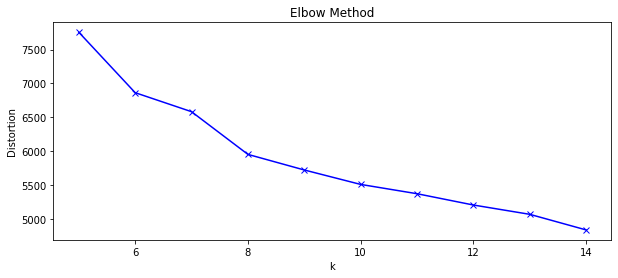

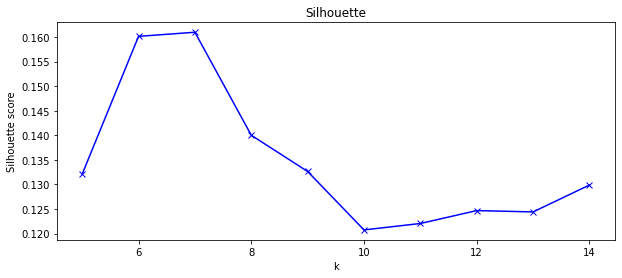

In [9]:
# Choose number of component for KMeans
distortions = []
silhouette = []
K = range(5, 15)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", random_state=0)
    kmeanModel.fit(ts_data)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(t_data, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [10]:
# Looking at the graph (Silhouette), we can choose 6 or 8 clusters. I choose 8 because the every boxs have more than 3 regions
n_clusters = 8
ts_kmeans_euclidian = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=0).fit(ts_data)
predict_ts_kmeans = ts_kmeans_euclidian.predict(ts_data)

In [11]:
clusters = pd.DataFrame([data_05.columns, predict_ts_kmeans]).T
clusters.columns = ['region', 'cluster']
clusters.tail(3)

region cluster
99    2118       5
100   2119       5
101   2168       5

In [12]:
np.unique(clusters.cluster.iloc[:101], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=object),
 array([17,  5, 14, 17, 12,  4, 15, 17], dtype=int64))

#### Построим графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

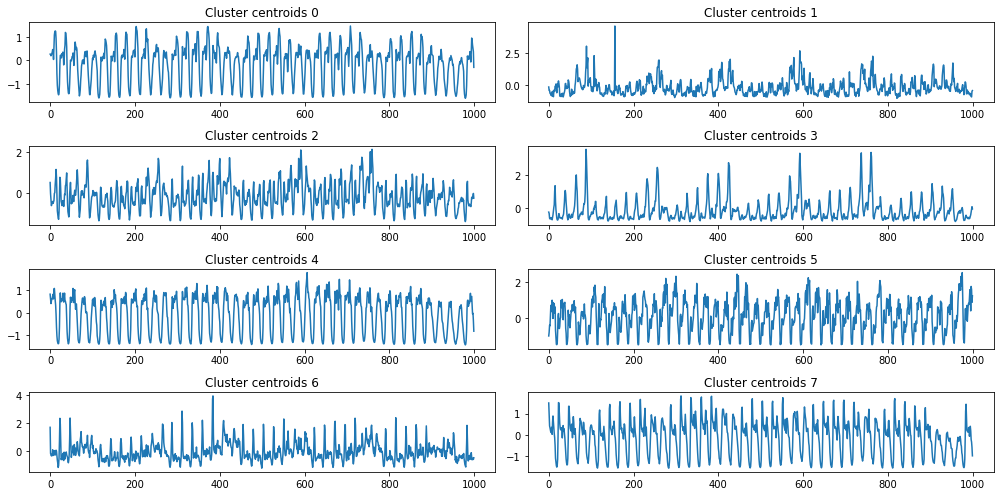

In [13]:
# Center of clusters for every cluster
fig, ax = plt.subplots(4, 2, figsize=(14, 7))
ax = ax.reshape(-1)

for cluster_number in range(n_clusters):
    # For last 1000 values
    ax[cluster_number].plot(ts_kmeans_euclidian.cluster_centers_[cluster_number, -1000:])
    ax[cluster_number].set_title("Cluster centroids" + ' ' + str(cluster_number))
    
plt.tight_layout()

49

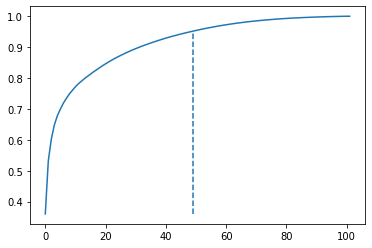

In [14]:
# Let's learn our values to PCA for vizualization
pca = PCA().fit(t_data)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_variance)
components_treshold = np.argwhere(explained_variance > 0.95).reshape(-1)[0]
plt.vlines(components_treshold, explained_variance.min(), 0.95, linestyles='dashed');
components_treshold

Сжали пространство признаков с 20424 до 49 с потерей точности в 5%

In [15]:
# Let's see how well the two-dimensional model describes our data
pca = PCA(n_components=components_treshold)
pca_transformed = pca.fit_transform(t_data)
np.sum(pca.explained_variance_ratio_[:2])

0.5319793570003696

In [16]:
# Three-dimensional
np.sum(pca.explained_variance_ratio_[:3])

0.6023024412480695

C:\Users\D683~1\AppData\Local\Temp/ipykernel_11628/488149232.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


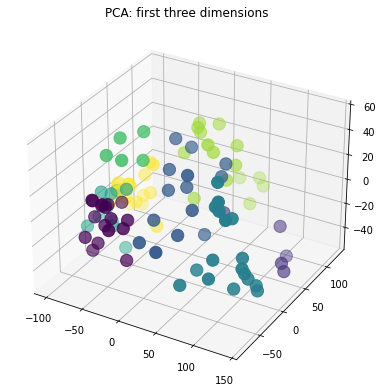

In [17]:
# Looking to our features in 3D
fig = plt.figure(figsize=(10, 5))
ax = Axes3D(fig)

ax.scatter(pca_transformed[:, 0], pca_transformed[:, 1], pca_transformed[:, 3], c=predict_ts_kmeans, s=150);
plt.title("PCA: first three dimensions")
plt.show();

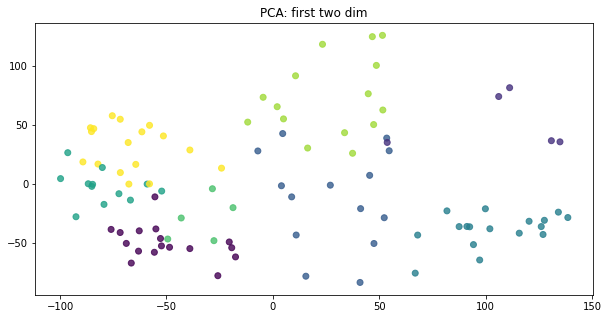

In [18]:
# PCA 2D
plt.figure(figsize=(10, 5))
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=predict_ts_kmeans, alpha=0.8)
plt.title("PCA: first two dim");

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0)
tsne_transformed = tsne.fit_transform(pca_transformed)

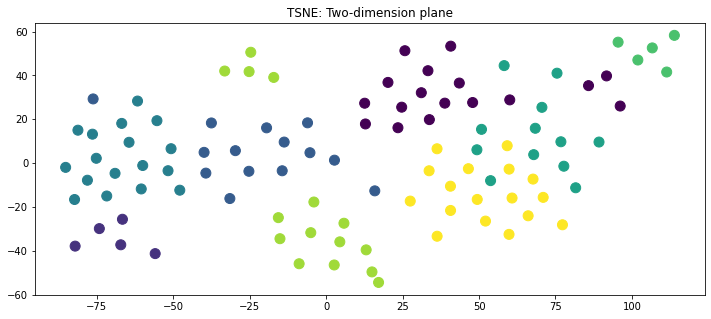

In [20]:
# TSNE 2D
plt.figure(figsize=(12, 5))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=predict_ts_kmeans, s=100)
plt.title("TSNE: Two-dimension plane");    

### 4. В каждом кластере выберем наиболее типичный ряд.

In [24]:
from tslearn.neighbors import KNeighborsTimeSeries

In [25]:
# Seach most typical series with method KNN for Time Series
knn = KNeighborsTimeSeries(n_neighbors=1, metric='euclidean', n_jobs=4).fit(ts_data) 
ind = knn.kneighbors(ts_kmeans_euclidian.cluster_centers_)

In [26]:
ind

(array([[42.83594973],
        [65.22727832],
        [60.89035746],
        [41.59367588],
        [38.97982246],
        [58.70733193],
        [75.83511146],
        [38.54577859]]),
 array([[35],
        [90],
        [31],
        [51],
        [56],
        [99],
        [71],
        [55]], dtype=int64))

In [27]:
# Get needed indexes and put their in new DataFrame (time*cluster)
# Not normalizated data
indx_knn = ind[1].reshape(1, n_clusters)[0]
typical_series = pd.DataFrame(data.iloc[:, indx_knn])
typical_series

1233  1533  1229  1326  1334  2118  1387  1333
2014-01-01 00:00:00   681    42  1126   177   718   106    74   939
2014-01-01 01:00:00   732   147  1119   253   709    87   165  1141
2014-01-01 02:00:00   540   204  1005   259   441    39   133   822
2014-01-01 03:00:00   849   169   978   316   263     5   105   438
2014-01-01 04:00:00   585   127   740   219   133    29    62   231
...                   ...   ...   ...   ...   ...   ...   ...   ...
2016-06-30 19:00:00   730     7   647    16   523   142    18   650
2016-06-30 20:00:00   707     8   608    23   439   209    35   526
2016-06-30 21:00:00   854     8   622    43   434   213    47   511
2016-06-30 22:00:00   945    26   689    62   272   206    27   410
2016-06-30 23:00:00   612    25   695    62   212   173    21   321

[21888 rows x 8 columns]

In [28]:
# Normalizated data 
indexes = pd.date_range(start='1/1/2014', end='7/1/2016', freq='H', closed='left')
ind_may = pd.date_range(start='1/1/2014', end='6/1/2016', freq='H', closed='left')
columns = data.iloc[:, indx_knn].columns
# Add indexes and columns to our normalizated data
norm_typical_series = pd.DataFrame(standardized_june[:, indx_knn], index=indexes, columns=columns)
norm_typical_series_may = pd.DataFrame(standardized_may[:, indx_knn], columns=columns, index=ind_may)
norm_typical_series

1233       1533      1229      1326      1334  \
2014-01-01 00:00:00  0.318102   2.695192  2.591904  3.945634  0.856887   
2014-01-01 01:00:00  0.478083  12.167514  2.563646  5.992757  0.827425   
2014-01-01 02:00:00 -0.124197  17.309631  2.103437  6.154372 -0.049893   
2014-01-01 03:00:00  0.845097  14.152191  1.994440  7.689715 -0.632589   
2014-01-01 04:00:00  0.016963  10.363262  1.033654  5.076939 -1.058153   
...                       ...        ...       ...       ...       ...   
2016-06-30 19:00:00  0.471809  -0.462249  0.658220 -0.391035  0.218540   
2016-06-30 20:00:00  0.399661  -0.372036  0.500781 -0.202484 -0.056440   
2016-06-30 21:00:00  0.860781  -0.372036  0.557297  0.336233 -0.072808   
2016-06-30 22:00:00  1.146237   1.251790  0.827771  0.848013 -0.603127   
2016-06-30 23:00:00  0.101658   1.161578  0.851992  0.848013 -0.799541   

                         2118      1387      1333  
2014-01-01 00:00:00 -0.357294  2.891918  1.298711  
2014-01-01 01:00:00 -0.614633  8.546571  1.924553  
2014-01-01 02:00:00 -1.264754  6.558121  0.936218  
2014-01-01 03:00:00 -1.725256  4.818228 -0.253501  
2014-01-01 04:00:00 -1.400196  2.146250 -0.894835  
...                       ...       ...       ...  
2016-06-30 19:00:00  0.130297 -0.587868  0.403323  
2016-06-30 20:00:00  1.037758  0.468496  0.019143  
2016-06-30 21:00:00  1.091934  1.214164 -0.027331  
2016-06-30 22:00:00  0.997125 -0.028617 -0.340252  
2016-06-30 23:00:00  0.550167 -0.401451 -0.615994  

[21888 rows x 8 columns]

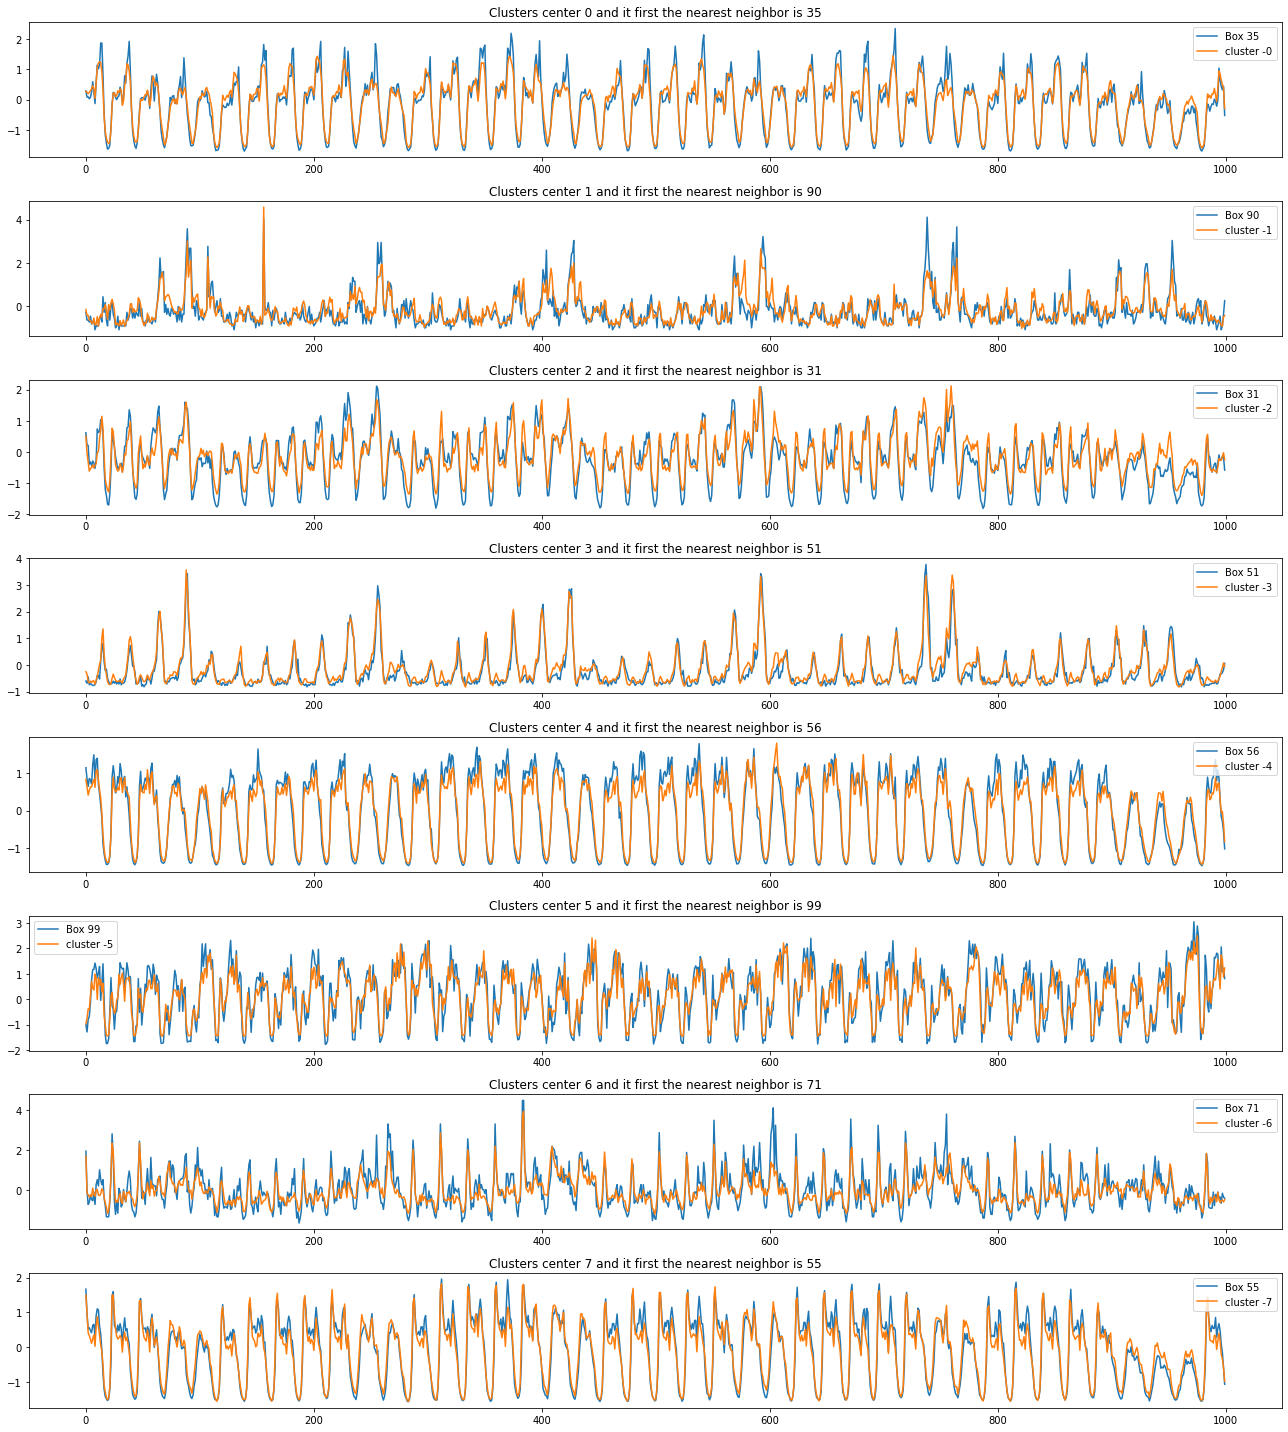

In [29]:
# Let's look clusters center and their first the nearest neighbors to 1000 last values.
plt.figure(figsize=(18, 20))

for i in range(n_clusters):
    num = 811+i
    plt.subplot(num)
    plt.plot(t_data[indx_knn[i], -1000:], label='Box '+ str(indx_knn[i]))
    plt.plot(ts_kmeans_euclidian.cluster_centers_[i, -1000:], label='cluster -'+str(i))
    plt.title('Clusters center {} and it first the nearest neighbor is {}'.format(i, indx_knn[i]))
    plt.legend();

plt.tight_layout();   

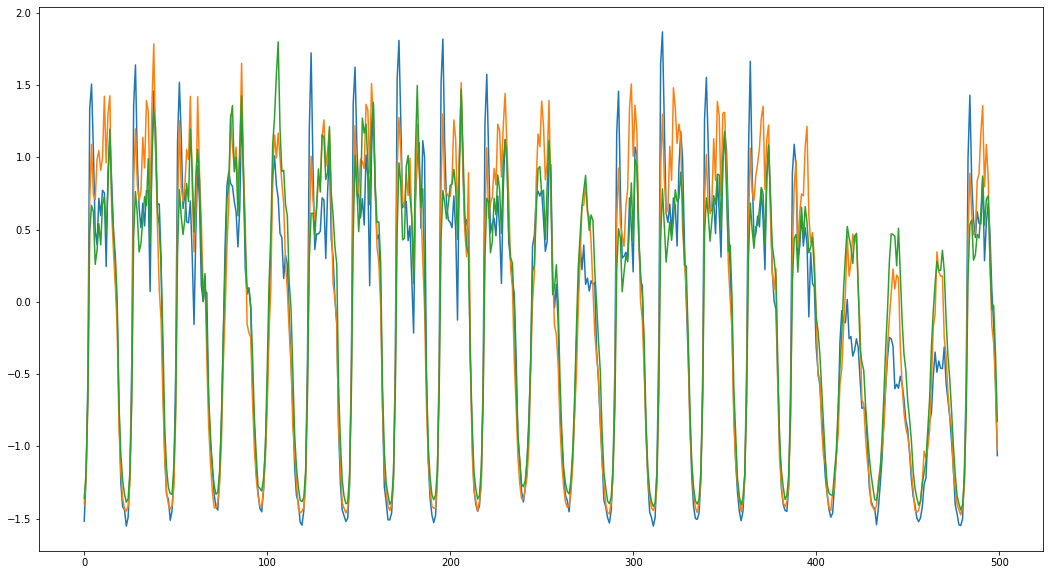

In [43]:
plt.figure(figsize=(18, 10))
plt.plot(t_data[55, -500:])
plt.plot(t_data[56, -500:])
plt.plot(ts_kmeans_euclidian.cluster_centers_[4, -500:]);

### 5. Для выбранных географических зон подберу на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p, d, q, P, D, Q — так, как это делалось на прошлой неделе. 
Не используйте данные за последний имеющийся месяц — май и июнь 2016!

In [44]:
from pandas.tseries.holiday import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, accuracy_score
# for features
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

In [45]:
# Create new df for date features
df_feats = pd.DataFrame(np.zeros((data.shape[0], 1)), columns=['holiday'])
df_feats.index = pd.date_range(start='1/1/2014', end='7/1/2016', freq='H', closed='left')
df_feats.shape

# Add holidays to data
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=datetime(2014, 1, 1), end=datetime(2016, 6, 30)) 
# Сonvert it to the needed format and substitute it in the data
h_days = pd.to_datetime(holidays).strftime('%Y-%m-%d')
for h in h_days:
    df_feats.holiday[h] = 1
    
# Add numbers of hours, weekday and weekends
df_feats["hour"] = df_feats.index.hour
df_feats["weekday"] = df_feats.index.weekday
df_feats["is_weekend"] = df_feats.weekday.isin([5, 6]) * 1
df_feats.sample(3)

holiday  hour  weekday  is_weekend
2014-10-31 21:00:00      0.0    21        4           0
2016-05-25 15:00:00      0.0    15        2           0
2016-05-21 05:00:00      0.0     5        5           1

In [46]:
# Create constant and new regression features matrix for seasons and trands to all clusters regions
pi = np.math.pi
K = 20
reg_feature = np.zeros((len(data), (K*4)+4))  
# Let's fill the array with features
for k in range(K):
    for i in range(len(reg_feature)):   
        # Week cicle
        reg_feature[i, k*4] = np.sin((i+1)*2*pi*(k+1)/168.)
        reg_feature[i, k*4+1] = np.cos((i+1)*2*pi*(k+1)/168.)
        # Year cicle
        reg_feature[i, k*4+2] = np.sin((i+1)*2*pi*(k+1)/8760)
        reg_feature[i, k*4+3] = np.cos((i+1)*2*pi*(k+1)/8760)
        
# Add holidays and X in reg_feature 
reg_feature[:, -1] = df_feats.holiday.values
reg_feature[:, -2] = df_feats.hour.values
reg_feature[:, -3] = df_feats.weekday.values
reg_feature[:, -4] = df_feats.is_weekend.values

reg_feature.shape

(21888, 84)

In [47]:
def get_features(norm_ts, offset):
    """This function return two arrays with exogenion values - X and X for predict"""    
    # Let's do values in needed format
    data_long = pd.DataFrame({0: norm_ts.iloc[:offset, i].values.flatten(),
                                1: np.arange(norm_ts.iloc[:offset, i].shape[0]).repeat(1)})
    data_long_pred = pd.DataFrame({0: norm_ts.iloc[offset:, i].values.flatten(),
                                    1: np.arange(norm_ts.iloc[offset:, i].shape[0]).repeat(1)})
    # Initialize features
    settings_minimal = settings.MinimalFCParameters()
    settings_time = settings.TimeBasedFCParameters()
    settings_time.update(settings_minimal)
    # Get Features
    X = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_time)
    X_pred = extract_features(data_long_pred, column_id=1, impute_function=impute, default_fc_parameters=settings_time)
        
    return X, X_pred

Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

Cluster - 0 , MAE: 0.007080170679254618


Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

Cluster - 1 , MAE: 0.00596253046870285


Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

Cluster - 2 , MAE: 0.008991910832866067


Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

Cluster - 3 , MAE: 0.007354158430951402


Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

Cluster - 4 , MAE: 0.0030052587664233734


Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

Cluster - 5 , MAE: 0.005024742894670122


Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

Cluster - 6 , MAE: 0.0023103179892407697


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.75it/s]


Cluster - 7 , MAE: 0.004964276151164104


(744, 8)

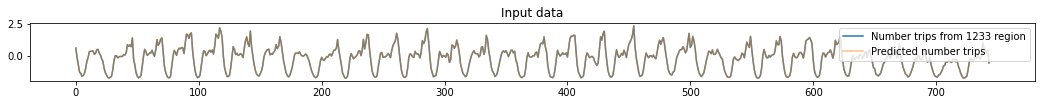

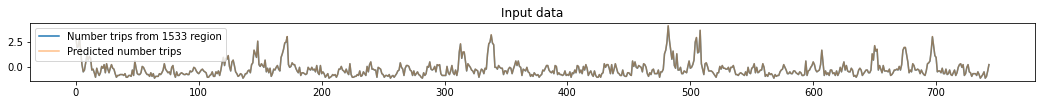

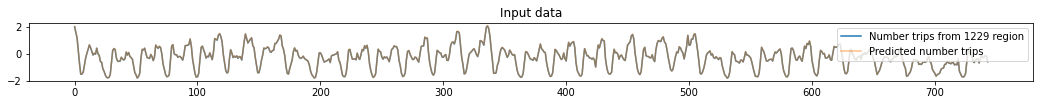

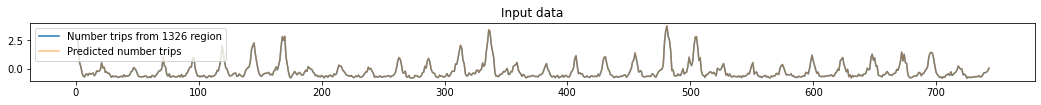

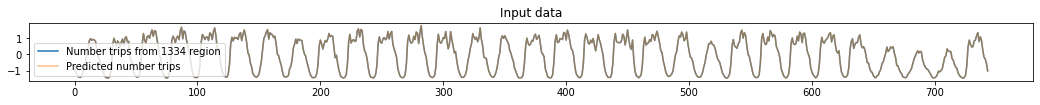

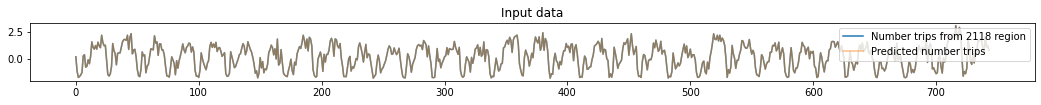

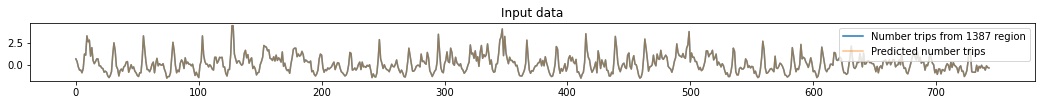

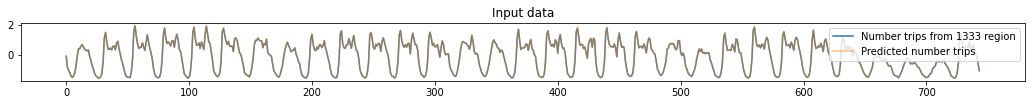

In [48]:
# 
reg_errors_may = np.zeros((744, n_clusters))
exog = []
exog_may = []

for i in range(n_clusters):
    # Get new features
    X, X_pred = get_features(norm_typical_series_may, -744)
    # Add sin and cos + holidays
    reg_features = np.hstack((X.values, reg_feature[:-1464, :]))
    reg_features_may = np.hstack((X_pred.values, reg_feature[-1464:-720, :]))
    
    exog.append(reg_features)
    exog_may.append(reg_features_may)
    
    # Fit Linear Regression
    lin_reg =  LinearRegression().fit(reg_features, norm_typical_series.iloc[:-1464, i].values)
    # Get predictions
    predict_lin_reg = lin_reg.predict(reg_features_may)
    # Vizualize    
    plt.figure(figsize=(18, 10))
    plt.subplot(n_clusters*100 + 10 + i+1)
    plt.plot(norm_typical_series_may.iloc[-744:, i].values, label='Number trips from {} region'.format(norm_typical_series.columns[i]))
    plt.plot(predict_lin_reg, label='Predicted number trips', alpha=0.5)
    plt.title('Input data')
    plt.legend()
    
    # Looks on their metrics
    mae_lin_reg = mean_absolute_error(norm_typical_series_may.iloc[-744:, i].values, predict_lin_reg)
    print('Cluster - {} , MAE: {}'.format(i, mae_lin_reg))
    
    reg_errors_may[:, i] = norm_typical_series_may.iloc[-744:, i].values - predict_lin_reg

reg_errors_may.shape

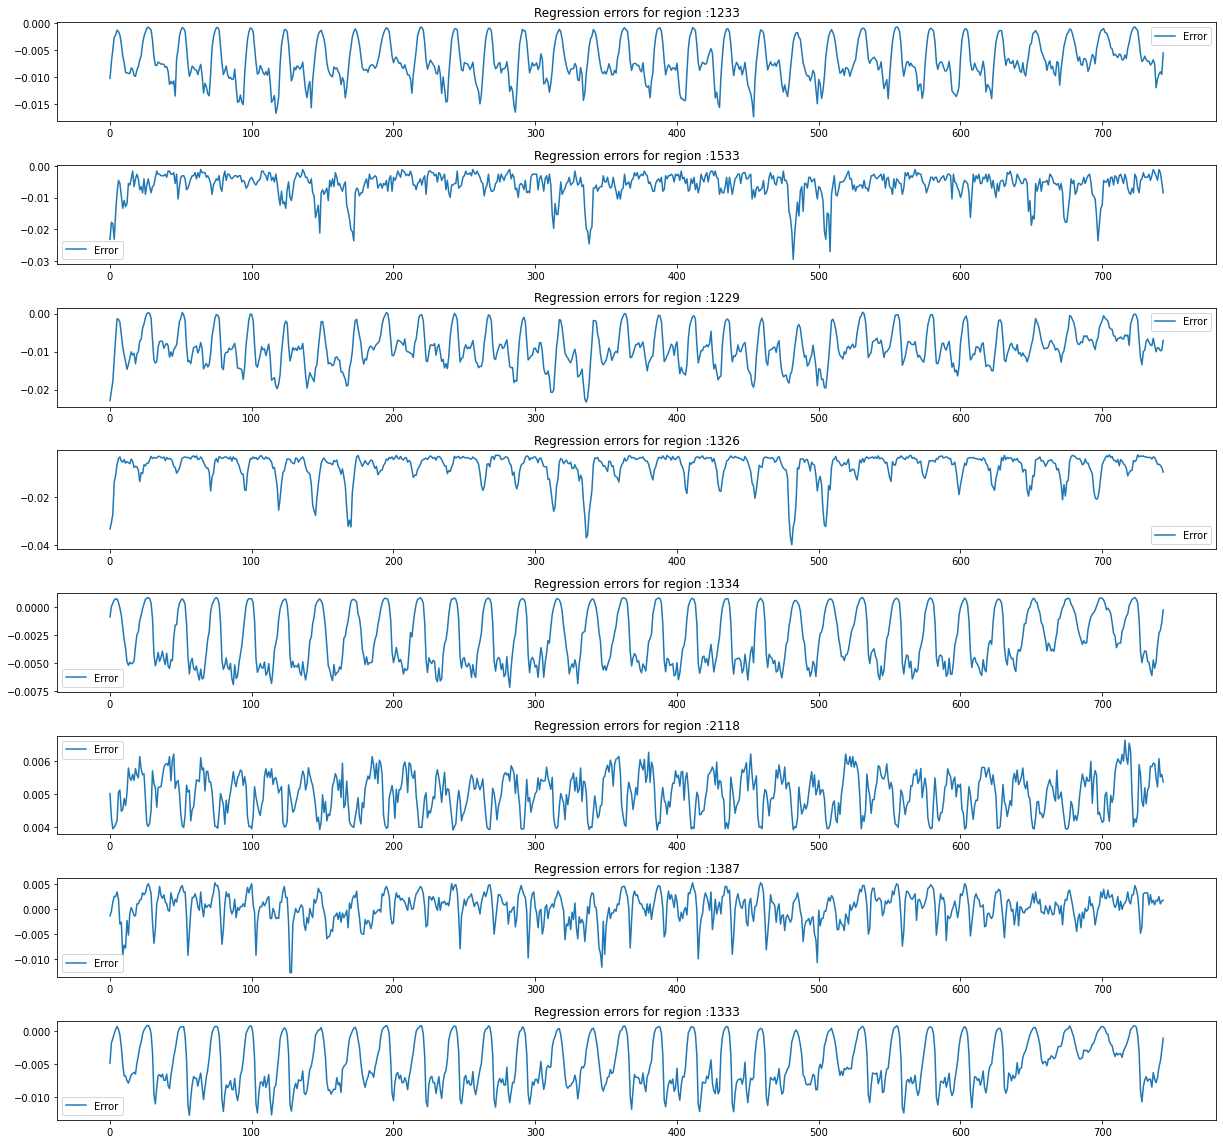

In [49]:
# Let's vizualizate regression errors
plt.figure(figsize=(17, 16))
for i in range(n_clusters):
    plt.subplot(n_clusters*100 + 10 + i+1)
    plt.plot(reg_errors_may[:, i], label='Error')
    plt.title('Regression errors for region :'+str(typical_series.columns[i]))
    plt.legend();

    plt.tight_layout();   

In [50]:
# Create new table of regression errors
indx = pd.date_range(start='5/1/2016', end='6/1/2016', freq='H', closed='left')
cols = ['error_'+str(norm_typical_series.columns[i]) for i in range(n_clusters)]
errors = pd.DataFrame(reg_errors_may, index=indx, columns=cols)
errors

error_1233  error_1533  error_1229  error_1326  \
2016-05-01 00:00:00   -0.010262   -0.023119   -0.022891   -0.033290   
2016-05-01 01:00:00   -0.007260   -0.017744   -0.020436   -0.030681   
2016-05-01 02:00:00   -0.004935   -0.018233   -0.017860   -0.026984   
2016-05-01 03:00:00   -0.002687   -0.023119   -0.012026   -0.013719   
2016-05-01 04:00:00   -0.002253   -0.014812   -0.006265   -0.010891   
...                         ...         ...         ...         ...   
2016-05-31 19:00:00   -0.010377   -0.004550   -0.008938   -0.006325   
2016-05-31 20:00:00   -0.009522   -0.001130   -0.009084   -0.006325   
2016-05-31 21:00:00   -0.009049   -0.002107   -0.009765   -0.006760   
2016-05-31 22:00:00   -0.009534   -0.005039   -0.009692   -0.007629   
2016-05-31 23:00:00   -0.005574   -0.008460   -0.007067   -0.009587   

                     error_1334  error_2118  error_1387  error_1333  
2016-05-01 00:00:00   -0.000904    0.005021   -0.001364   -0.004791  
2016-05-01 01:00:00    0.000022    0.004280   -0.000451   -0.001774  
2016-05-01 02:00:00    0.000318    0.003948    0.001375   -0.001058  
2016-05-01 03:00:00    0.000597    0.003994    0.002470   -0.000330  
2016-05-01 04:00:00    0.000693    0.004079    0.002470    0.000314  
...                         ...         ...         ...         ...  
2016-05-31 19:00:00   -0.003419    0.005222    0.001557   -0.006962  
2016-05-31 20:00:00   -0.002381    0.006086    0.002470   -0.005435  
2016-05-31 21:00:00   -0.002085    0.005530    0.001009   -0.004529  
2016-05-31 22:00:00   -0.001407    0.005608    0.001557   -0.002895  
2016-05-31 23:00:00   -0.000281    0.005376    0.001740   -0.001022  

[744 rows x 8 columns]

In [51]:
def plot_stationarity(column, diff=False, data=errors):
    """This function draw stationarity tables"""
    plt.figure(figsize(16, 10))
    if diff == True:
        # Week difference and 1 hour
        diff_168 = data[column] - data[column].shift(168)
        diff_168_1 = diff_168 - diff_168.shift(1)
        if column in ['error_1281', 'error_1326', 'error_2118']:
            diff_168_1 = diff_168
        
        sm.tsa.seasonal_decompose(diff_168_1[169:]).plot();
        pylab.show();
        
    elif diff == False:
        sm.tsa.seasonal_decompose(data[column].iloc[-600:]).plot();
        pylab.show();
    
def plot_autocorr(column, data=errors):
    '''This function draw difference errors of got column to 168 hour (1 week) and then 1 hour'''
    
    # Week difference and 1 hour
    diff_168 = data[column] - data[column].shift(168)
    diff_168_1 = diff_168 - diff_168.shift(1)
    if column in ['error_1281', 'error_1326', 'error_2118']:
        diff_168_1 = diff_168

    plt.figure(figsize=(15,8))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(diff_168_1[169:], lags=168, ax=ax)

    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(diff_168_1[169:], lags=168, ax=ax)
    pylab.show();

<Figure size 1152x720 with 0 Axes>

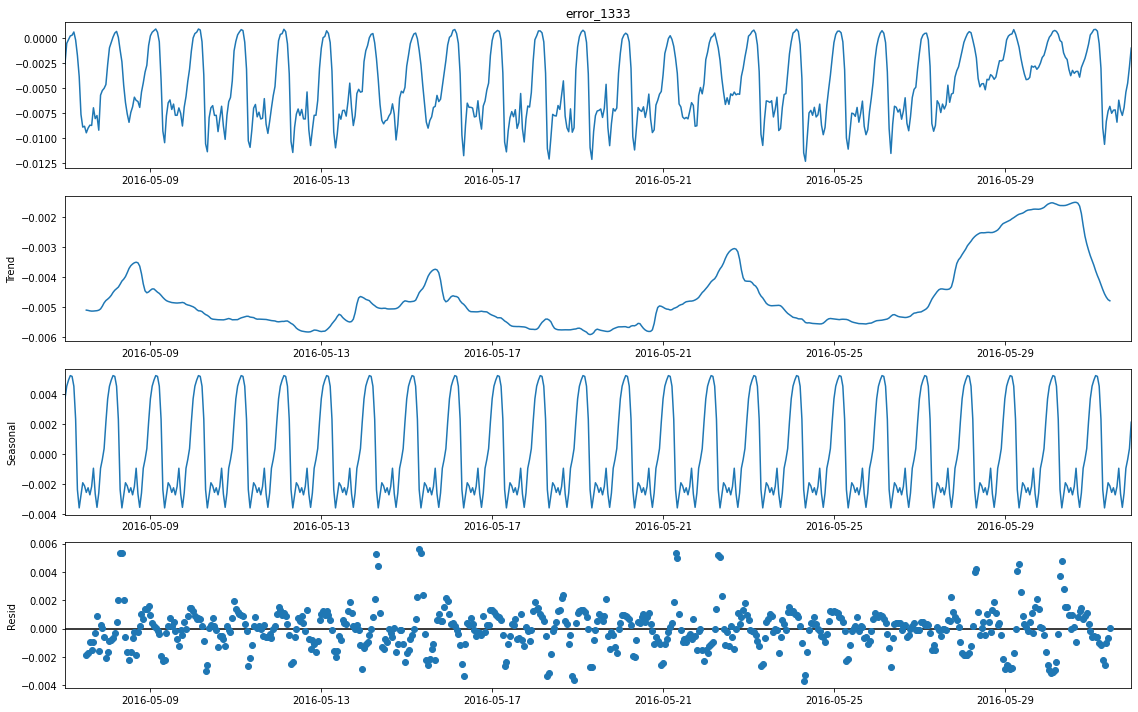

In [52]:
# Let's check stationarity
plot_stationarity('error_1333');

<Figure size 1152x720 with 0 Axes>

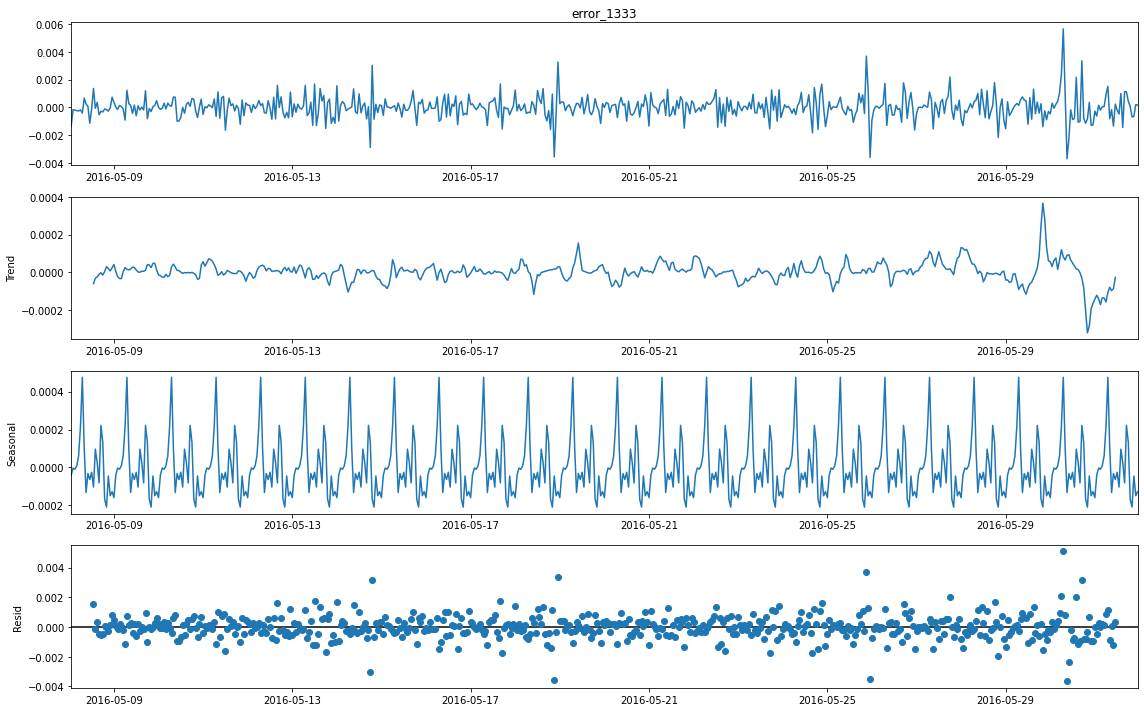

In [39]:
# Let's check stationarity with difference
plot_stationarity('error_1333', diff=True);

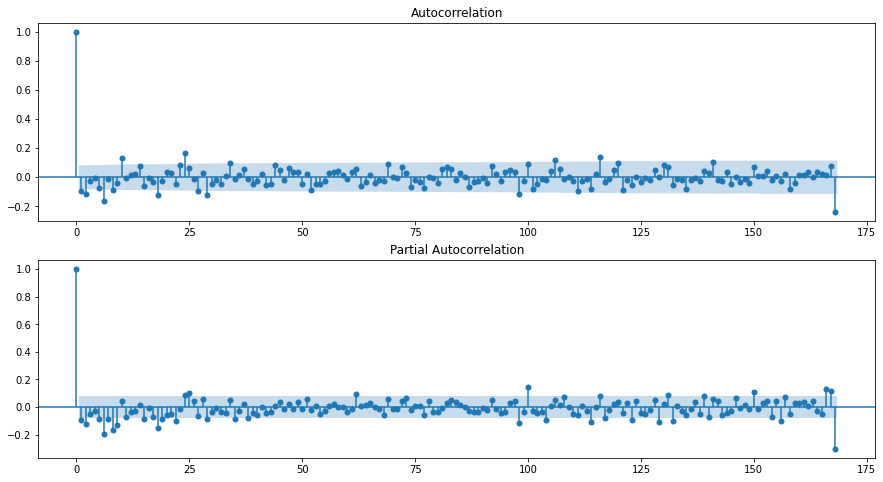

In [53]:
# Draw ACF and PACF
plot_autocorr('error_1333')

Глядя на графики можно предположить начальные приближения:
Q и q - Autocorrelation, P и p - Partial Autocorrelation
1. Номер максимального сезонного лага, значимо отличающегося от нуля (Q). Только значение за n часов назад имеет значение.
2. Номер последнего несезонного лага, значимо отличающиеся от нуля (q) -  Это для  MA
3. Номер последнего сезонного лага, значимо отличающийся от 0 (P)  
4. Номер последнего несезонного лага, значимо отличающийся от 0 (p) - Это для авторегрессии 

In [58]:
# (p, d, q), (P, D, Q, seasonal lag)
parameters = [[(2, 0, 1), (1, 0, 1, 24)], [(3, 0, 1), (1, 0, 1, 24)], 
             [(1, 0, 1), (1, 0, 1, 24)], [(1, 0, 5), (1, 0, 1, 24)],
             [(2, 0, 1), (1, 0, 1, 24)], [(3, 0, 7), (1, 0, 1, 24)],
             [(2, 0, 1), (1, 0, 1, 24)], [(2, 0, 2), (1, 0, 1, 24)]]

In [42]:
# Let's fit our clusters
predicted_models_may = []

for i in range(8):
    warnings.filterwarnings('ignore')
    
    fit_exog = sm.add_constant(exog[i][-744:])
    fit_data = norm_typical_series_may.iloc[-744:, i].values

    model = sm.tsa.statespace.SARIMAX(endog=fit_data, exog=fit_exog, 
                                      order=parameters[i][0], seasonal_order=parameters[i][1])
    fitted_model = model.fit(disp=False)
    
    # Save parametrs of models
    predicted_models_may.append(fitted_model.params)
    print('Success')

predicted_models_may[0].shape

Success
Success
Success
Success
Success
Success
Success
Success


(99,)

In [54]:
norm_typical_series_may.shape

(21168, 8)

In [56]:
data[-2184:-1464]

1075  1076  1077  1125  1126  1127  1128  1129  1130  \
2016-04-01 00:00:00    46    55    31    67   171   300   521   603   716   
2016-04-01 01:00:00    25    44    16    46    90   228   325   436   598   
2016-04-01 02:00:00    12    23    13    20    58   146   177   299   557   
2016-04-01 03:00:00     8     9     4    20    32   141    70   164   498   
2016-04-01 04:00:00     9    13     4    16    33   115    55   129   239   
...                   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2016-04-30 19:00:00   121   209   145   101   345   445   519   724   817   
2016-04-30 20:00:00   107   208    99   107   290   411   543   733   840   
2016-04-30 21:00:00    91   155   108   115   318   463   600   875   831   
2016-04-30 22:00:00   100    97    85   100   217   421   697   955   909   
2016-04-30 23:00:00    92   118    63    86   284   529   733   838   918   

                     1131  ...  1630  1684  1733  1734  1783  2068  2069  \
2016-04-01 00:00:00   161  ...     4     0     2   158    50   104    14   
2016-04-01 01:00:00   121  ...     8     0     4     3    16    67    14   
2016-04-01 02:00:00    55  ...     9     0     0     0     1    18     2   
2016-04-01 03:00:00    52  ...     4     0     2     0     0     0     0   
2016-04-01 04:00:00    21  ...     8     1     3     3     2     1     0   
...                   ...  ...   ...   ...   ...   ...   ...   ...   ...   
2016-04-30 19:00:00   244  ...     1     0     5   152    83   140     5   
2016-04-30 20:00:00   210  ...     2     0     2   141    41   119    11   
2016-04-30 21:00:00   152  ...     2     0     2   190    67   129    16   
2016-04-30 22:00:00   203  ...     1     0     2   230    80   132    21   
2016-04-30 23:00:00   185  ...     4     0     0   195    54   134    10   

                     2118  2119  2168  
2016-04-01 00:00:00   175    53    96  
2016-04-01 01:00:00   165    13    68  
2016-04-01 02:00:00    26     0     7  
2016-04-01 03:00:00     6     0     1  
2016-04-01 04:00:00    10     0     1  
...                   ...   ...   ...  
2016-04-30 19:00:00   158    59    84  
2016-04-30 20:00:00   232    50   120  
2016-04-30 21:00:00   158    81   117  
2016-04-30 22:00:00   198    23    93  
2016-04-30 23:00:00   181    74    39  

[720 rows x 102 columns]

In [59]:
# Let's fit our clusters
predicted_models_may = []

for i in range(8):
    # Fit our data in April
    fit_exog = sm.add_constant(exog[i][-720:])
    fit_data = norm_typical_series.iloc[-2184:-1464, i].values
    # endog = fit_data
    model = sm.tsa.statespace.SARIMAX(endog=fit_data, exog=fit_exog, 
                                      order=parameters[i][0], seasonal_order=parameters[i][1])
    fitted_model = model.fit(disp=False)
    
    # Save parametrs of models
    predicted_models_may.append(fitted_model.params)
    print('Success')

C:\Conda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Success
Success


C:\Conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Conda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Success


C:\Conda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Success


C:\Conda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Success
Success


C:\Conda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Success


C:\Conda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Success


### 6. Для каждой из R географических зон настроим на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитаем в ноутбуке ошибку прогноза по следующему функционалу.

In [43]:
norm_typical_series_may.iloc[:-744, 0].shape, exog[0].shape

((20424,), (20424, 93))

In [60]:
# Learn model with Kalman filter at all cluster
filtered_models_may = []
for cluster in range(n_clusters):
    mod = sm.tsa.SARIMAX(endog=norm_typical_series_may.iloc[:-744, cluster].values, exog=exog[cluster],
                         order=parameters[cluster][0], seasonal_order=parameters[cluster][1])
    res = mod.filter(predicted_models_may[cluster])
    filtered_models_may.append(res)

In [45]:
pd.to_datetime('2016-05-31 18:00:00'), pd.to_datetime('2016-04-30 23:00:00')

(Timestamp('2016-05-31 18:00:00'), Timestamp('2016-04-30 23:00:00'))

In [94]:
predict_may = np.zeros((6, 739, 102))

# Circle by regions
for region in range(102):

    # Get number of cluster and name of column
    cluster = clusters.iloc[region, 1]
    col = norm_typical_series_may.columns[cluster]
    
    for T in range(6): 
        
        if T <= 4:
            may_predict = filtered_models_may[cluster].predict(start=20424+T, end=20424+738+T,
                                                               exog=exog_may[cluster][:-5+T], dynamic=True)
        # if -744:0(-5+5) - error    
        elif T > 4:
            may_predict = filtered_models_may[cluster].predict(start=20424+T, end=20424+738+T, 
                                                               exog=exog_may[cluster], dynamic=True)
        
        predict_may[T, :, region] = may_predict

In [65]:
# Create new np.array for real data may and june: 6 lags of hours * columns(715) * regions(102)
y = np.zeros((6, data.shape[0], 102))
# Create samples for every y
for i in range(1, 7):
    y[i-1] = data.shift(-i).values
    
may = y[:, -1465:-726, :]  
june = y[:, 21167:21882, :]
june.shape, may.shape

((6, 715, 102), (6, 739, 102))

In [66]:
# Inverse transform for count Q may error
Q_m = 0
for q in range(6):
    Q_m += sum(abs(may[q, :, :] - scaler.inverse_transform(predict_may[q, :, :]))) / (739*102*6)
    
Q_m

28.90890774823766

In [67]:
may.shape

(6, 739, 102)

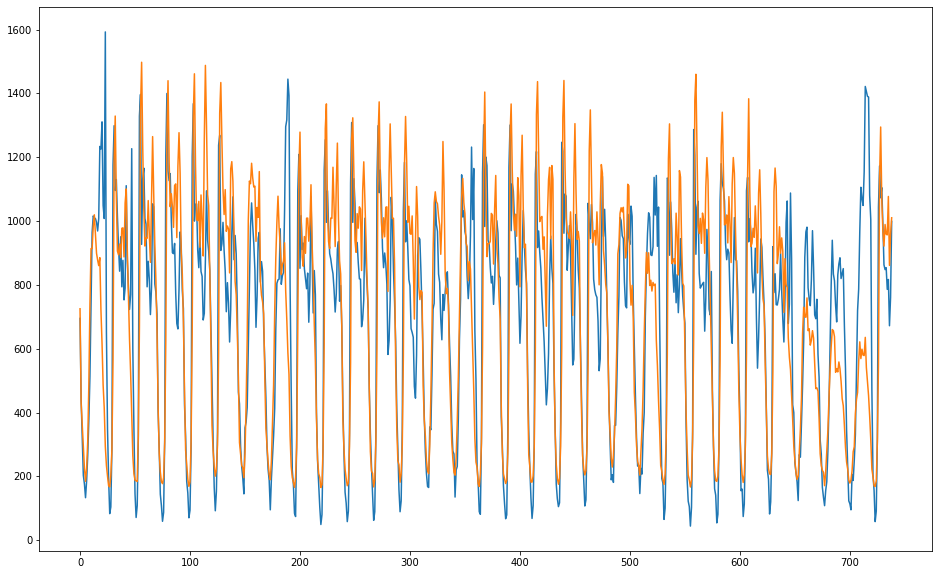

In [68]:
sc_inv_trnsfrm = scaler.inverse_transform(predict_may[0, :, :])
plt.plot(may[0, :, 20]) 
plt.plot(sc_inv_trnsfrm[:, 20]);
#plt.plot(sc_inv_trnsfrm[:, 19]);

### 7. Для каждой из R географических зон настроим на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл.
формат файла: **id, y**, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [54]:
# # Download fitted models
# model_params_june = []
# for i in range(8):
#     name = 'SARIMA_params_june_{}.csv'.format(i)
#     model_params_june.append(np.genfromtxt(name, delimiter=','))
# model_params_june[0].shape

In [69]:
# Create needed massive
reg_errors_june = np.zeros((720, n_clusters))
exog_j = []
exog_june = []

# Regression
for i in range(n_clusters):
    # Get new features
    X, X_pred = get_features(norm_typical_series, -720)
    # Add sin and cos + holidays
    reg_features = np.hstack((X.values, reg_feature[:-720, :]))
    reg_features_june = np.hstack((X_pred.values, reg_feature[-720:, :]))
    
    exog_j.append(reg_features)
    exog_june.append(reg_features_june)
    
    # Fit Linear Regression
    lin_reg =  LinearRegression().fit(reg_features, norm_typical_series.iloc[:-720, i].values)
    # Get predictions
    predict_lin_reg = lin_reg.predict(reg_features_june)
    # Looks on their metrics
    mae_lin_reg = mean_absolute_error(norm_typical_series.iloc[-720:, i].values, predict_lin_reg)
    print('Cluster - {} , MAE: {}'.format(i, mae_lin_reg))
    # Save errors
    reg_errors_june[:, i] = norm_typical_series.iloc[-720:, i].values - predict_lin_reg

Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

Cluster - 0 , MAE: 2.1897944491650673e-15


Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

Cluster - 1 , MAE: 2.3026907348492702e-14


Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

Cluster - 2 , MAE: 6.2366302940490444e-15


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


Cluster - 3 , MAE: 7.066243086418295e-14


Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

Cluster - 4 , MAE: 9.90044755282909e-15


Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

Cluster - 5 , MAE: 4.063560830417737e-15


Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

Cluster - 6 , MAE: 1.656853666610737e-15


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


Cluster - 7 , MAE: 1.2804385192468719e-14


In [70]:
# Create new table of regression errors
indx = pd.date_range(start='6/1/2016', end='7/1/2016', freq='H', closed='left')
errors_june = pd.DataFrame(reg_errors_june, index=indx, columns=cols)
errors_june

error_1233    error_1533    error_1229    error_1326  \
2016-06-01 00:00:00  6.217249e-15  2.409184e-14 -1.265654e-14  1.013079e-14   
2016-06-01 01:00:00  7.771561e-15  2.570166e-14 -1.110223e-14 -7.105427e-15   
2016-06-01 02:00:00  8.215650e-15  2.375877e-14 -7.993606e-15 -3.907985e-14   
2016-06-01 03:00:00  7.105427e-15  2.964295e-14 -5.329071e-15 -7.704948e-14   
2016-06-01 04:00:00  3.330669e-15  1.704192e-14 -3.330669e-15 -6.078471e-14   
...                           ...           ...           ...           ...   
2016-06-30 19:00:00 -2.386980e-15  2.536860e-14  6.328271e-15 -5.417888e-14   
2016-06-30 20:00:00 -1.443290e-15  2.581269e-14  9.880985e-15 -3.927414e-14   
2016-06-30 21:00:00 -8.881784e-16  2.725598e-14  1.132427e-14  1.554312e-14   
2016-06-30 22:00:00 -4.440892e-16 -1.154632e-14  9.880985e-15  7.560619e-14   
2016-06-30 23:00:00  2.442491e-15 -9.325873e-15  1.065814e-14  7.027712e-14   

                       error_1334    error_2118    error_1387    error_1333  
2016-06-01 00:00:00 -1.887379e-14 -8.881784e-16  2.886580e-15 -2.020606e-14  
2016-06-01 01:00:00 -1.820766e-14 -4.829470e-15  5.107026e-15 -1.909584e-14  
2016-06-01 02:00:00 -1.687539e-14 -5.995204e-15  4.884981e-15 -1.731948e-14  
2016-06-01 03:00:00 -1.554312e-14 -3.996803e-15  4.884981e-15 -1.554312e-14  
2016-06-01 04:00:00 -1.598721e-14 -1.998401e-15  5.329071e-15 -1.376677e-14  
...                           ...           ...           ...           ...  
2016-06-30 19:00:00  1.268430e-14 -7.716050e-15  8.881784e-16  1.593170e-14  
2016-06-30 20:00:00  1.331574e-14 -8.881784e-16  4.996004e-16  2.021300e-14  
2016-06-30 21:00:00  1.508516e-14  1.776357e-15 -1.332268e-15  2.233283e-14  
2016-06-30 22:00:00  1.354472e-14  3.108624e-15  1.238593e-15  2.464695e-14  
2016-06-30 23:00:00  1.409983e-14  1.443290e-15  8.881784e-16  2.686740e-14  

[720 rows x 8 columns]

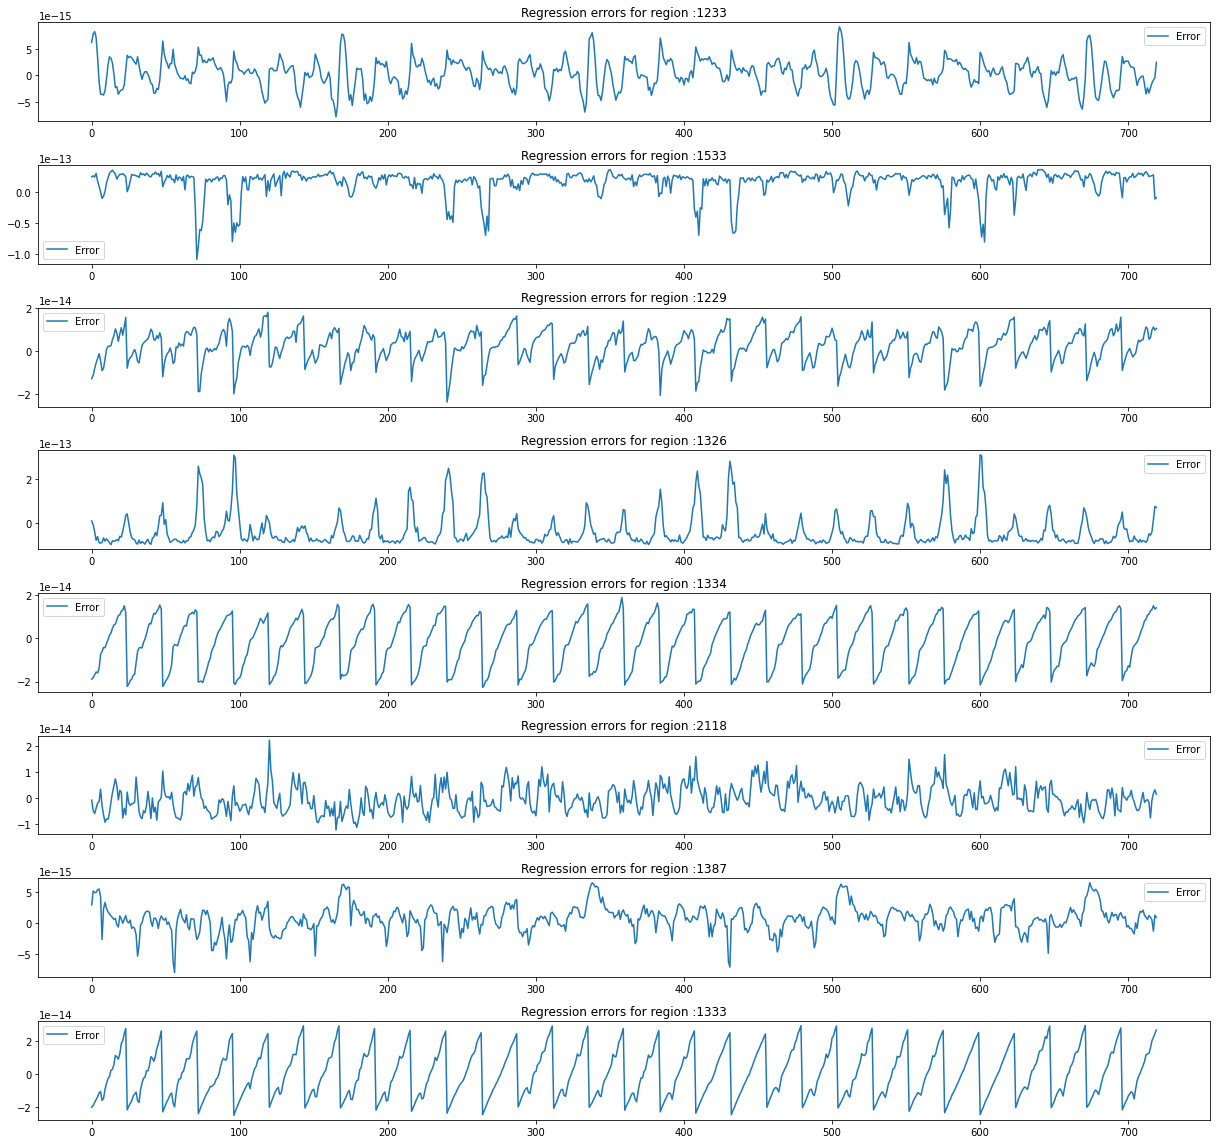

In [71]:
# Let's vizualizate regression errors
plt.figure(figsize=(17, 16))
for i in range(n_clusters):
    plt.subplot(n_clusters*100 + 10 + i+1)
    plt.plot(reg_errors_june[:, i], label='Error')
    plt.title('Regression errors for region :'+str(typical_series.columns[i]))
    plt.legend();

    plt.tight_layout();   

In [72]:
def plot_stationarity(column, diff=False, data=errors):
    """This function draw stationarity tables"""
    plt.figure(figsize(16, 10))
    if diff == True:
        # Week difference and 1 hour
        diff_168 = data[column] - data[column].shift(168)
        diff_168_1 = diff_168 - diff_168.shift(1)
        if column in ['error_1281', 'error_1326', 'error_2118']:
            diff_168_1 = diff_168
        
        sm.tsa.seasonal_decompose(diff_168_1[169:]).plot();
        pylab.show();
        
    elif diff == False:
        sm.tsa.seasonal_decompose(data[column].iloc[-600:]).plot();
        pylab.show();
    
def plot_autocorr(column, data=errors):
    '''This function draw difference errors of got column to 168 hour (1 week) and then 1 hour'''
    
    # Week difference and 1 hour
    diff_168 = data[column] - data[column].shift(168)
    diff_168_1 = diff_168 - diff_168.shift(1)
    if column in ['error_1285', 'error_1387', 'error_1385', 'error_2118', 'error_1229', 'error_1333']:#, 'error_1281']:
        diff_168_1 = diff_168

    plt.figure(figsize=(15,8))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(diff_168_1[193:], lags=168, ax=ax)

    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(diff_168_1[193:], lags=168, ax=ax)
    pylab.show();

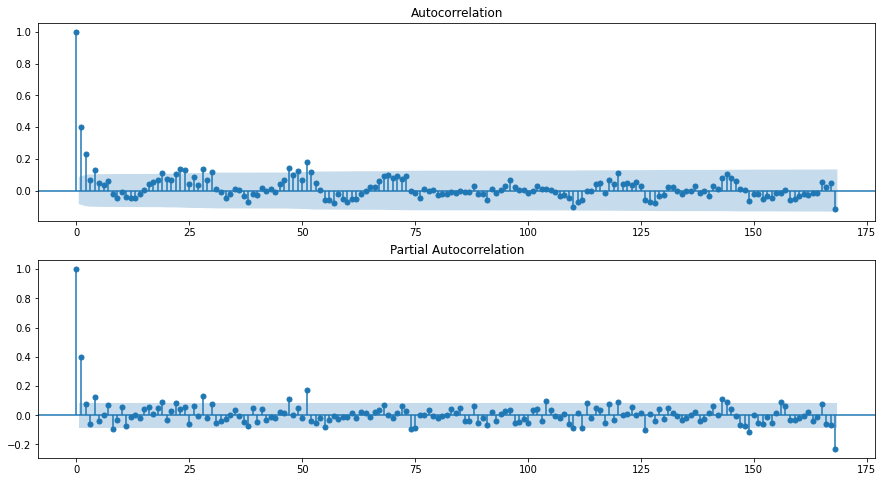

In [73]:
plot_autocorr('error_1333', data=errors_june)

In [74]:
# (p, d, q), (P, D, Q, seasonal lag)
parameters = [[(5, 0, 1), (1, 0, 1, 24)], [(3, 0, 1), (1, 0, 1, 24)], 
             [(1, 0, 3), (1, 0, 1, 24)], [(4, 0, 2), (1, 0, 1, 24)],
             [(6, 0, 2), (1, 0, 1, 24)], [(4, 0, 6), (1, 0, 1, 24)],
             [(1, 0, 9), (1, 0, 1, 24)], [(1, 0, 2), (1, 0, 1, 24)]]

In [75]:
fitted_model.params.shape

(100,)

In [77]:
# Let's fit our clusters and then filter
filtered_models_june = []

for i in range(8):
    warnings.filterwarnings('ignore')
    # Creating and fitting the model at 3 months
    fit_exog = sm.add_constant(exog_j[i][-1464:])
    fit_data = norm_typical_series_may.iloc[-1464:, i].values

    model = sm.tsa.statespace.SARIMAX(endog=fit_data, exog=fit_exog, 
                                      order=parameters[i][0], seasonal_order=parameters[i][1])
    fitted_model = model.fit(disp=False)
    
    # Filtering our model
    mod = sm.tsa.SARIMAX(norm_typical_series.iloc[:-720, i], exog=sm.add_constant(exog_j[i]),
                         order=parameters[i][0], seasonal_order=parameters[i][1])
    res = mod.filter(fitted_model.params)
    # Save
    filtered_models_june.append(res)
    
    print('Success')

Success
Success
Success
Success
Success
Success
Success
Success


In [79]:
# Create array for predict june
predict_june = np.zeros((6, 715, 102))

# Circle by regions
for region in range(102):
    # Get number of cluster and name of column
    cluster = clusters.iloc[region, 1]
    col = norm_typical_series.columns[cluster]

    for T in range(6):    
        
        if T <= 4:
            june_pred = filtered_models_june[cluster].predict(start=21168+T, end=21168+714+T, 
                                                              exog=exog_june[cluster][:-5+T], dynamic=True)
        elif T > 4:
            june_pred = filtered_models_june[cluster].predict(start=21168+T, end=21168+714+T, 
                                                              exog=exog_june[cluster], dynamic=True)
            
        # save predict
        predict_june[T, :, region] = june_pred.values

In [ ]:
# Save
for i in range(6):
    name = 'predict_june_T_{}.csv'.format(i+1)
    np.savetxt(name, predict_june[i], delimiter=",")

In [80]:
# Inverse transform for count Q may error
inv_scale_june = np.zeros((6, 715, 102))
Q_june = 0
for q in range(6):
    inv_scale_june[q, :, :] = scaler.inverse_transform(predict_june[q, :, :])
    Q_june += sum(abs(june[q, :, :] - inv_scale_june[q, :, :]))  / (715*102*6)
    
Q_june

30.653738944579633

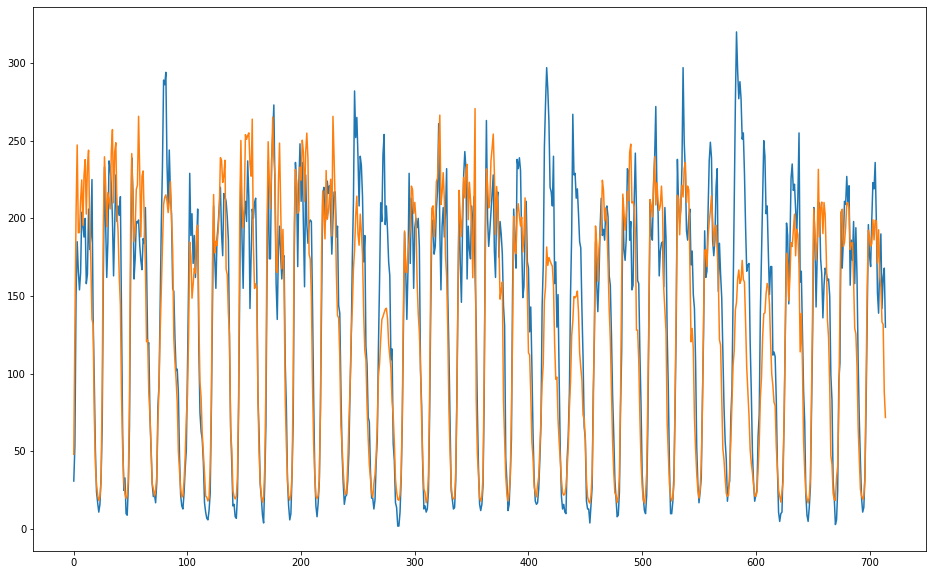

In [91]:
plt.plot(june[5, :, 1])
plt.plot(inv_scale_june[5, :, 1]);

In [83]:
# 714 * 6 * 102
per = pd.date_range(start='5/31/2016', end='7/1/2016', freq='H', closed='left')
period = per[23:-6]

In [84]:
# Let's write answer to needed format region_year-month-day_hour_T
kaggle_pred = []
for region in range(102):
    reg = data.columns[region]
    for i in range(len(june[0])):
        for T in range(6):
            if inv_scale_june[T, i, region] < 0:
                inv_scale_june[T, i, region] = 0
            kaggle_pred.append([str(reg)+'_'+str(period[i].strftime('%Y-%m-%d_'))+str(period[i].hour)+str('_')+str(T+1), 
                                inv_scale_june[T, i, region]])
            #print(str(reg)+'_'+str(period[i].strftime('%Y-%m-%d_%H'))+str('_')+str(T+1), inv_scale_june[T, i, region])
            
len(kaggle_pred)

437580

In [92]:
# Save 
kaggle = pd.DataFrame(kaggle_pred, columns=['id', 'y'])
kaggle['id'] = kaggle['id'].astype(str)
kaggle.to_csv('kaggle_june_SARIMAX.csv', sep=',', index=False)
kaggle

id          y
0       1075_2016-05-31_23_1  22.751861
1       1075_2016-05-31_23_2   4.513120
2       1075_2016-05-31_23_3   0.000000
3       1075_2016-05-31_23_4   0.000000
4       1075_2016-05-31_23_5   0.000000
...                      ...        ...
437575  2168_2016-06-30_17_2  64.641722
437576  2168_2016-06-30_17_3  97.239342
437577  2168_2016-06-30_17_4  99.197237
437578  2168_2016-06-30_17_5  95.792409
437579  2168_2016-06-30_17_6  79.734610

[437580 rows x 2 columns]

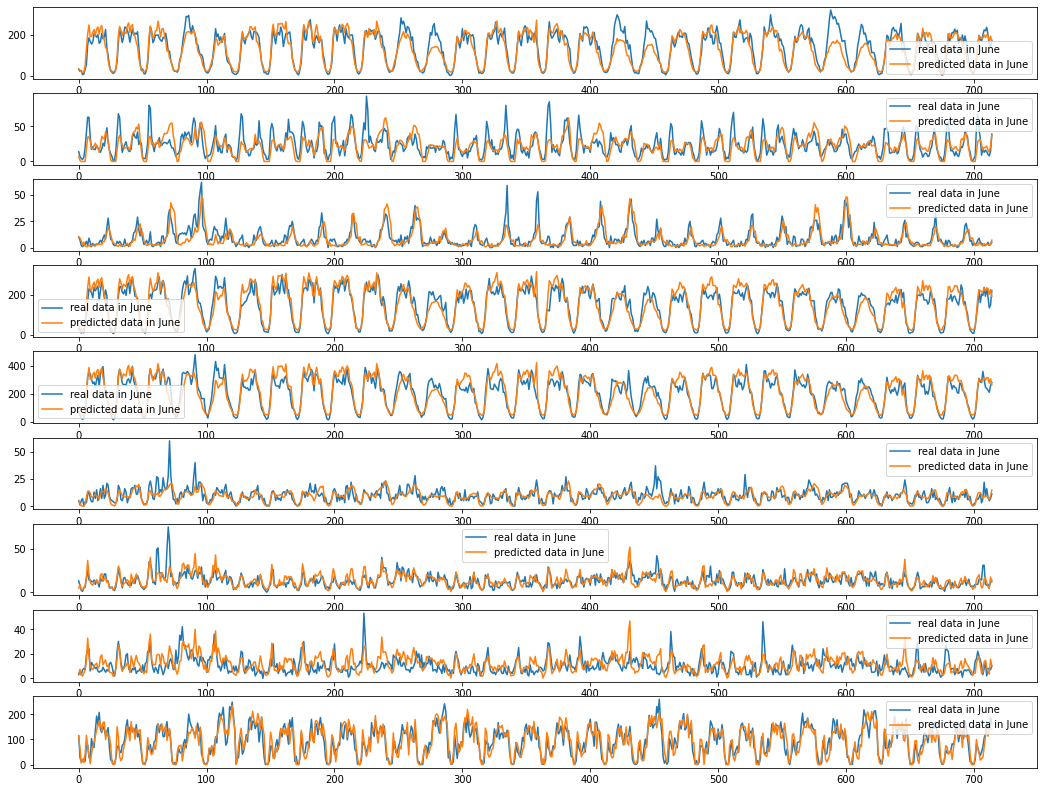

In [93]:
plt.figure(figsize=(18, 14))
n = 1
for i in range(1, 102, 12):
    plt.subplot(910+n)
    n += 1
    plt.plot(june[0, :, i], label='real data in June')
    plt.plot(inv_scale_june[0, :, i], label='predicted data in June')
    plt.legend()

Результат конечно же можно улучшить, но требуется большей мощности и времени. Как мне кажется лучше сделать прогноз SARIMAX для ошибки от регрессии и добавить его к результатам регрессии